---

## Setup and Imports

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Survival Analysis ---
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, brier_score

# --- Notebook Settings ---
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


---

## Load Data

In [2]:
# Define date columns for parsing
customer_date_cols = ['registration_date', 'churn_date']
transaction_date_cols = ['transaction_date']
service_date_cols = ['ticket_date']

# Load datasets
df_customers = pd.read_csv('data/customers.csv', parse_dates=customer_date_cols)
df_transactions = pd.read_csv('data/transactions.csv', parse_dates=transaction_date_cols)
df_app_usage = pd.read_csv('data/app_usage.csv')
df_service = pd.read_csv('data/customer_service.csv', parse_dates=service_date_cols)

print("--- customers.csv info ---")
df_customers.info()
print("\n--- transactions.csv info ---")
df_transactions.info()
print("\n--- app_usage.csv info ---")
df_app_usage.info()
print("\n--- customer_service.csv info ---")
df_service.info()

--- customers.csv info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        10005 non-null  object        
 1   age                9813 non-null   float64       
 2   state              9928 non-null   object        
 3   account_age_days   10005 non-null  int64         
 4   tier               10005 non-null  object        
 5   device_type        9500 non-null   object        
 6   kyc_status         10005 non-null  object        
 7   registration_date  10005 non-null  datetime64[ns]
 8   is_churned         10005 non-null  int64         
 9   churn_date         2359 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 781.8+ KB

--- transactions.csv info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775050 entries, 0 to 775049
Data columns

---

## Investigate and Clean Impossible Churn Dates
Found this issue while training the model where some rows contain churn_date lower than registration_date

In [3]:
# 1. Identify rows where churn_date is before registration_date
impossible_rows = df_customers[
    (df_customers['is_churned'] == 1) & 
    (df_customers['churn_date'] < df_customers['registration_date'])
]

print(f"Found {len(impossible_rows)} rows with impossible churn dates (churn_date < registration_date).")

if len(impossible_rows) > 0:
    print("\n--- Sample of Impossible Rows (to be removed) ---")
    print(impossible_rows[['customer_id', 'registration_date', 'churn_date', 'is_churned']].head())

# 2. Filter the main customers DataFrame to remove these rows
original_count = len(df_customers)
df_customers = df_customers.drop(impossible_rows.index)

print(f"\nRemoved {original_count - len(df_customers)} impossible rows.")
print(f"New 'df_customers' size: {len(df_customers)}")

Found 189 rows with impossible churn dates (churn_date < registration_date).

--- Sample of Impossible Rows (to be removed) ---
    customer_id registration_date churn_date  is_churned
3   CUST_000004        2024-10-14 2024-10-03           1
7   CUST_000008        2024-10-25 2024-10-13           1
8   CUST_000009        2024-10-27 2024-10-08           1
14  CUST_000015        2024-10-26 2024-10-22           1
16  CUST_000017        2024-10-16 2024-10-04           1

Removed 189 impossible rows.
New 'df_customers' size: 9816


---

## Exploratory Data Analysis

#### Target Variable Distribution
let's understand our class balance. A highly imbalanced dataset would require different modeling strategies than a balanced one.

Total Customers: 9816
Churned Customers: 2170
Overall Churn Rate: 22.11%


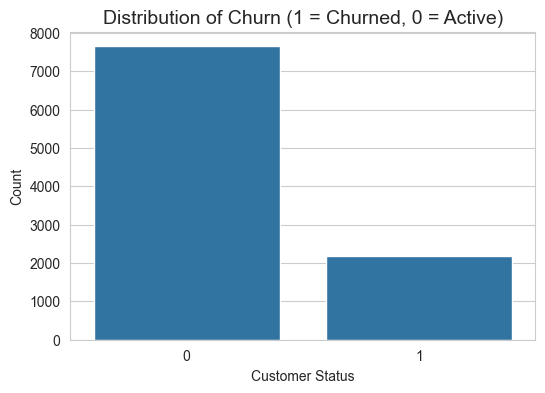

In [4]:
# Set the style
sns.set_style("whitegrid")

# Calculate churn rate
total_customers = len(df_customers)
churned_customers = df_customers['is_churned'].sum()
churn_rate = (churned_customers / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"Churned Customers: {churned_customers}")
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_customers, x='is_churned')
plt.title('Distribution of Churn (1 = Churned, 0 = Active)', fontsize=14)
plt.xlabel('Customer Status')
plt.ylabel('Count')
plt.show()

This plot shows the absolute count of active (0) vs. churned (1) customers.

* **Insight:** We can see a clear class imbalance. Based on the notebook's calculation, our overall churn rate is **22.11%**.
* **Observation:** While this is imbalanced, it is not an extreme case (like a 1% or 5% churn rate). This is significant enough to be a major concern for the business. For our modeling, this means we must use **stratified sampling** for our train-test split to ensure both datasets have a similar proportion of churners. We will also prioritize metrics like the **C-Index** over simple accuracy.

---

#### Numerical Features vs. Churn
Let's see how age and account_age_days (our main numerical features) relate to churn.

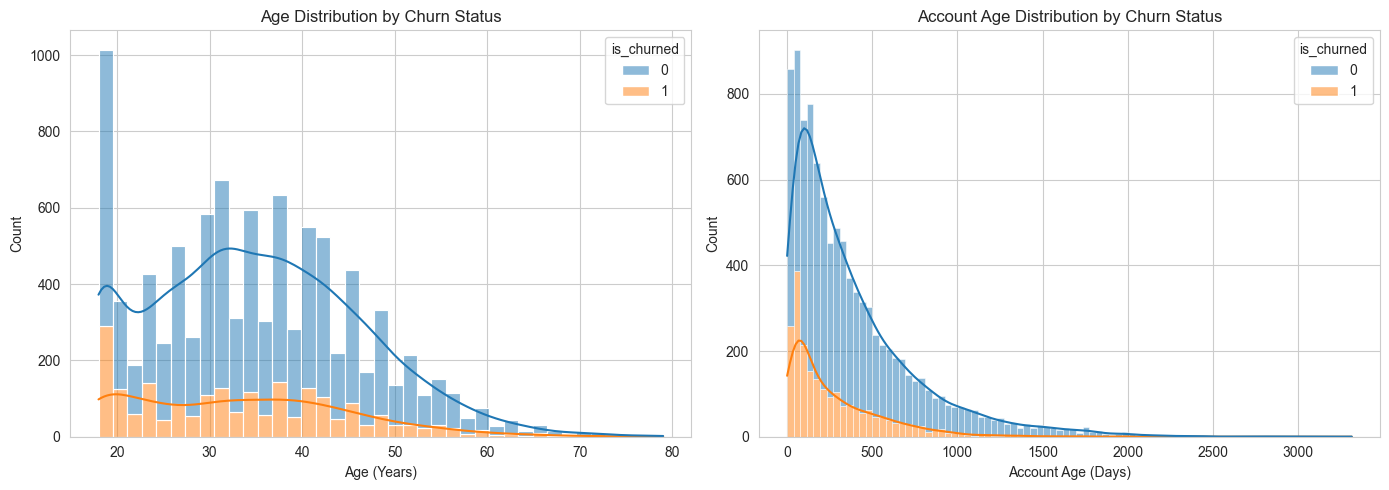

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Age
sns.histplot(data=df_customers, x='age', hue='is_churned', multiple="stack", kde=True, ax=axes[0])
axes[0].set_title('Age Distribution by Churn Status')
axes[0].set_xlabel('Age (Years)')

# Plot for Account Age
sns.histplot(data=df_customers, x='account_age_days', hue='is_churned', multiple="stack", kde=True, ax=axes[1])
axes[1].set_title('Account Age Distribution by Churn Status')
axes[1].set_xlabel('Account Age (Days)')

plt.tight_layout()
plt.show()

These plots show the distribution of customer `age` and `account_age_days` (customer tenure), stacked by their churn status.

* **Age (Left Plot):** Churn appears to happen across all age groups. The distribution of churned users (orange) follows the overall customer distribution fairly closely, though it seems slightly more concentrated among younger users in the 20-35 age range.
* **Account Age (Right Plot):** This is a critical insight. The churned population (orange) is **heavily skewed to the left**, with a massive peak in the 0-250 day range. The active population (blue) is much more spread out. This strongly suggests that **"Infant Churn"** is a major problem. Customers are at the highest risk of leaving very early in their lifecycle.

---

#### Categorical Features (Churn Rate per Category)
Instead of just counting, let's plot the churn rate for our key categories.

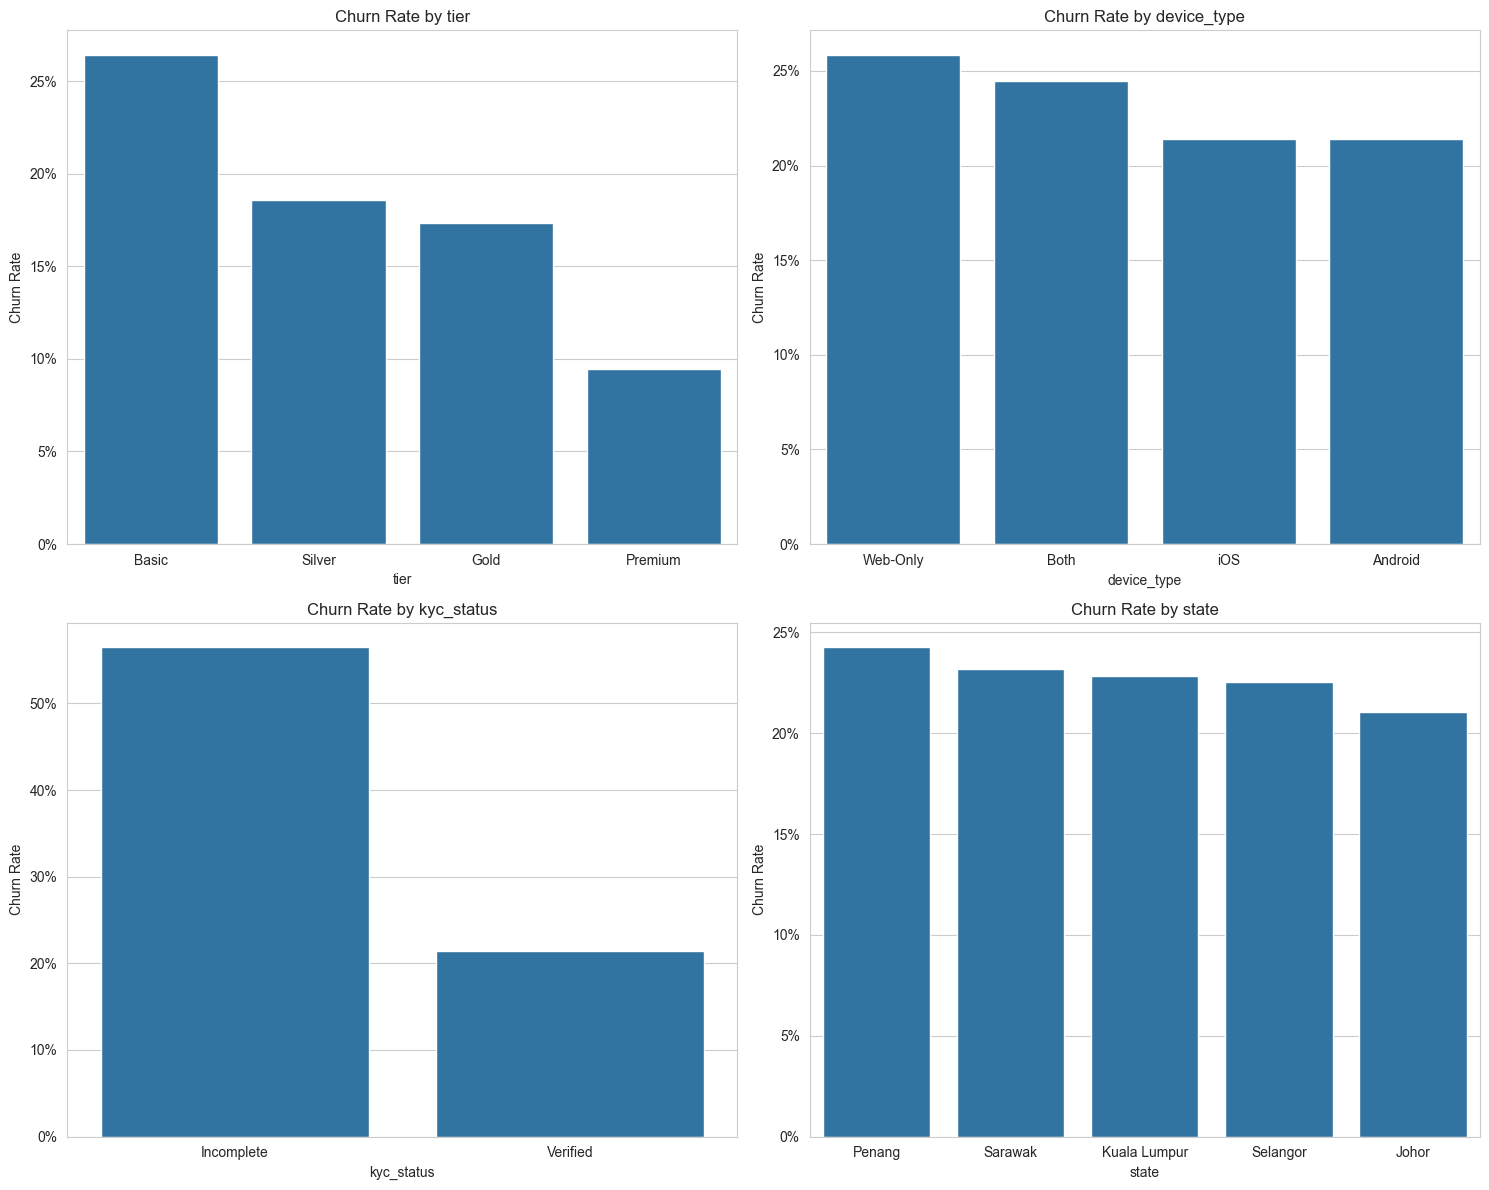

In [6]:
# We'll look at tier, device_type, and state
cat_features = ['tier', 'device_type', 'kyc_status', 'state']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten() # Flatten the 2x2 grid to make looping easier

# Fill NaNs in device_type for this plot, just as we do in the pipeline
df_customers['device_type'] = df_customers['device_type'].fillna('Web-Only')

for i, col in enumerate(cat_features):
    # For 'state', the plot is too crowded. Let's just take the top 5 states.
    if col == 'state':
        top_states = df_customers['state'].value_counts().head(5).index
        plot_data = df_customers[df_customers['state'].isin(top_states)]
    else:
        plot_data = df_customers
        
    # Calculate churn rate for each category
    churn_rate_df = plot_data.groupby(col)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False)
    
    # Plot
    sns.barplot(data=churn_rate_df, x=col, y='is_churned', ax=axes[i], order=churn_rate_df[col])
    axes[i].set_title(f'Churn Rate by {col}')
    axes[i].set_ylabel('Churn Rate')
    axes[i].set_xlabel(col)
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) # Format y-axis as percentage

plt.tight_layout()
plt.show()

These plots show the *churn rate* (the proportion of churners) for our key categorical features, which is more insightful than just the raw counts.

* **KYC Status (Bottom-Left):** This is the most powerful predictor we've seen. Customers with **'Incomplete' KYC have a churn rate over 50%**. This is a critical friction point; if a user doesn't complete this step, we are very likely to lose them.
* **Tier (Top-Left):** We see a clear, inverse relationship. The **'Basic' tier churns the most** (over 25%), while **'Premium' users are the most loyal** (under 10%). This shows a strong link between product engagement and retention.
* **Device Type (Top-Right):** **'Web-Only' users churn at the highest rate**. Native app users (iOS/Android/Both) are slightly stickier, which supports the hypothesis that app engagement drives retention.
* **State (Bottom-Right):** Churn rates are very consistent (21-24%) across the top 5 states. This suggests that, at least among these major regions, geography is **not** a strong driver of churn.

---

#### Customer Service Satisfaction vs. Churn
let's see if there's a connection between low satisfaction scores and churn.

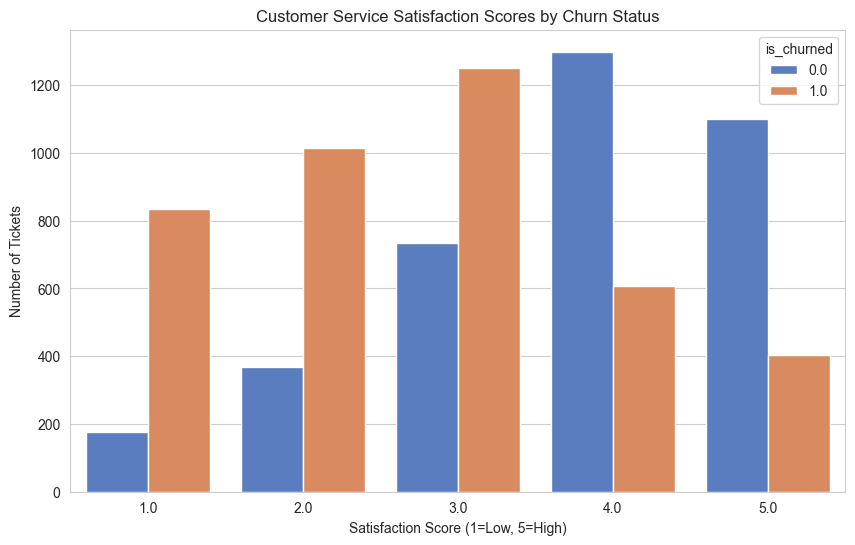

In [7]:
# Merge df_service with df_customers to get the 'is_churned' flag
df_service_churn = df_service.merge(df_customers[['customer_id', 'is_churned']], on='customer_id', how='left')

plt.figure(figsize=(10, 6))
sns.countplot(data=df_service_churn, x='satisfaction_score', hue='is_churned', palette='muted')
plt.title('Customer Service Satisfaction Scores by Churn Status')
plt.xlabel('Satisfaction Score (1=Low, 5=High)')
plt.ylabel('Number of Tickets')
plt.show()

This plot shows the count of customer service tickets for each satisfaction score (1=Low, 5=High), broken down by churn status.

* **Insight:** There is a very strong correlation between satisfaction and retention.
* **Active Customers (Blue):** The distribution is skewed to the **right**, with most tickets resulting in good scores (4 or 5).
* **Churned Customers (Orange):** The distribution is heavily skewed to the **left**, with a large number of tickets resulting in poor scores (1 or 2). A negative customer service interaction is a clear signal of high churn risk.

---

## Define Target Variable (Y) & Observarion Date
For survival analysis, target y is not a single column. It's a structured array containing two pieces of information:
- Event: is_churned (1 if they churned, 0 if they are still active).
- Duration: The time from registration to churn, or from registration to today if they are still active.

set up the obs_end_date which will be time-travel "wall" for feature engineering to avoid data leakage where the model seeing the future.

In [8]:
# 1. Find the 'analysis_date' (the last known date in the data)
analysis_date = df_transactions['transaction_date'].max()
print(f"Analysis Date (latest transaction): {analysis_date}")

# 2. Calculate duration for all customers
# This is the "ground truth" duration for target 'y'
df_customers['duration_days'] = (df_customers['churn_date'].fillna(analysis_date) - df_customers['registration_date']).dt.days

# 3. Define the 'Observation End Date' for FEATURES
# For churned users, stop looking at data ON their churn date.
# For active users, stop looking at data at the end of the analysis period.
df_customers['obs_end_date'] = df_customers['churn_date'].fillna(analysis_date)

# 4. Check for and remove any remaining impossible data
# (e.g., duration < 0, or obs_end_date before registration_date)
impossible_data = df_customers[
    (df_customers['duration_days'] < 0) | 
    (df_customers['obs_end_date'] < df_customers['registration_date'])
]
if len(impossible_data) > 0:
    print(f"Removing {len(impossible_data)} rows with impossible negative durations.")
    df_customers = df_customers.drop(impossible_data.index)

print("\n--- Target & Observation Date Setup ---")
print(df_customers[['customer_id', 'is_churned', 'duration_days', 'obs_end_date']].head())

# This is the 'anchor' DataFrame used to filter other tables
df_customer_time_anchor = df_customers[['customer_id', 'obs_end_date']]

Analysis Date (latest transaction): 2024-10-31 22:00:00

--- Target & Observation Date Setup ---
   customer_id  is_churned  duration_days        obs_end_date
0  CUST_000001           1             13 2024-10-24 00:00:00
1  CUST_000002           0             24 2024-10-31 22:00:00
2  CUST_000003           0              6 2024-10-31 22:00:00
4  CUST_000005           1             14 2024-10-26 00:00:00
5  CUST_000006           0             18 2024-10-31 22:00:00


---

## Feature Engineering

to avoid data leakage to the model:
- Merge df_transactions with df_customer_time_anchor.
- Filter out all transactions that happened after a customer's obs_end_date.
- Then, perform the groupby.agg on the filtered data.

#### transactions.csv. group by customer_id to get frequency and monetary style features.

In [9]:
# 1. Merge transactions with the time anchor
transactions_timed = df_transactions.merge(df_customer_time_anchor, on='customer_id')

# 2. Filter transactions to only those before or on the obs_end_date
transactions_filtered = transactions_timed[
    transactions_timed['transaction_date'] <= transactions_timed['obs_end_date']
].copy()

print(f"Original transactions: {len(df_transactions)}, Filtered transactions: {len(transactions_filtered)}")

# 3. Now, aggregate on this filtered DataFrame
transactions_features = transactions_filtered.groupby('customer_id').agg(
    total_transactions_count=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    failed_transactions_count=pd.NamedAgg(column='status', aggfunc=lambda x: (x == 'Failed').sum()),
    total_amount=pd.NamedAgg(column='amount', aggfunc='sum'),
    avg_amount=pd.NamedAgg(column='amount', aggfunc='mean'),
    unique_merchants=pd.NamedAgg(column='merchant_name', aggfunc='nunique'),
    unique_categories=pd.NamedAgg(column='category', aggfunc='nunique')
).reset_index()

print("\n--- Transaction Features ---")
print(transactions_features.head())

Original transactions: 775050, Filtered transactions: 775064

--- Transaction Features ---
   customer_id  total_transactions_count  failed_transactions_count  \
0  CUST_000002                        22                          0   
1  CUST_000003                         6                          0   
2  CUST_000006                         4                          0   
3  CUST_000010                         3                          0   
4  CUST_000012                         3                          0   

   total_amount  avg_amount  unique_merchants  unique_categories  
0        953.36   43.334545                11                  6  
1        173.42   28.903333                 3                  3  
2         60.46   15.115000                 4                  3  
3        104.16   34.720000                 3                  2  
4        427.83  142.610000                 3                  2  


#### app_usage.csv. aggregate this monthly data to get a customer-level view of engagement.

In [10]:
# 1. Convert 'month' (string) to a 'month_start_date' timestamp
df_app_usage['month_date'] = pd.to_datetime(df_app_usage['month'], format='%Y-%m')

# 2. Merge with the time anchor
app_usage_timed = df_app_usage.merge(df_customer_time_anchor, on='customer_id')

# 3. Filter app usage to only months before or on the obs_end_date
# check if the start of the usage month is before the observation end date
app_usage_filtered = app_usage_timed[
    app_usage_timed['month_date'] <= app_usage_timed['obs_end_date']
].copy()

print(f"Original app usage rows: {len(df_app_usage)}, Filtered rows: {len(app_usage_filtered)}")

# 4. Aggregate on the filtered data
app_usage_features = app_usage_filtered.groupby('customer_id').agg(
    avg_logins_count=pd.NamedAgg(column='logins_count', aggfunc='mean'),
    total_crash_count=pd.NamedAgg(column='crash_count', aggfunc='sum'),
    avg_features_used=pd.NamedAgg(column='features_used_count', aggfunc='mean'),
    avg_session_duration=pd.NamedAgg(column='avg_session_duration_mins', aggfunc='mean')
).reset_index()

# 5. Get the latest notification settings from the filtered data
latest_settings = app_usage_filtered.sort_values('month_date').drop_duplicates('customer_id', keep='last')
latest_settings = latest_settings[['customer_id', 'push_notifications_enabled', 'email_notifications_enabled']]

# 6. Merge
app_usage_features = app_usage_features.merge(latest_settings, on='customer_id', how='left')

print("\n--- App Usage Features ---")
print(app_usage_features.head())

Original app usage rows: 60030, Filtered rows: 58944

--- App Usage Features ---
   customer_id  avg_logins_count  total_crash_count  avg_features_used  \
0  CUST_000001         12.916667                2.0           4.916667   
1  CUST_000002         23.666667                2.0           4.333333   
2  CUST_000003          2.272727                2.0           1.833333   
3  CUST_000005          1.416667                0.0           1.454545   
4  CUST_000006          3.000000                2.0           1.333333   

   avg_session_duration  push_notifications_enabled  \
0             10.617000                         1.0   
1             32.915455                         0.0   
2             11.308333                         0.0   
3             10.590000                         0.0   
4              5.776000                         1.0   

   email_notifications_enabled  
0                          1.0  
1                          1.0  
2                          1.0  
3          

#### customer_service.csv. This gives insight into the customer's support experience.

In [11]:
# 1. Merge service tickets with the time anchor
service_timed = df_service.merge(df_customer_time_anchor, on='customer_id')

# 2. Filter tickets to only those before or on the obs_end_date
service_filtered = service_timed[
    service_timed['ticket_date'] <= service_timed['obs_end_date']
].copy()

print(f"Original service tickets: {len(df_service)}, Filtered tickets: {len(service_filtered)}")

# 3. Aggregate on the filtered data
service_features = service_filtered.groupby('customer_id').agg(
    total_tickets=pd.NamedAgg(column='ticket_id', aggfunc='count'),
    high_priority_tickets=pd.NamedAgg(column='priority', aggfunc=lambda x: (x == 'High').sum()),
    open_tickets=pd.NamedAgg(column='status', aggfunc=lambda x: (x == 'Open').sum()),
    avg_resolution_time_hours=pd.NamedAgg(column='resolution_time_hours', aggfunc='mean'),
    avg_satisfaction_score=pd.NamedAgg(column='satisfaction_score', aggfunc='mean')
).reset_index()

print("\n--- Customer Service Features ---")
print(service_features.head())

Original service tickets: 8516, Filtered tickets: 7831

--- Customer Service Features ---
   customer_id  total_tickets  high_priority_tickets  open_tickets  \
0  CUST_000001              4                      0             0   
1  CUST_000002             10                      0             0   
2  CUST_000003              6                      0             0   
3  CUST_000005             12                      0             0   
4  CUST_000006              1                      0             0   

   avg_resolution_time_hours  avg_satisfaction_score  
0                  20.320000                2.500000  
1                  25.480000                3.400000  
2                  38.103333                4.333333  
3                  30.466667                2.166667  
4                  33.780000                5.000000  


#### Merge the engineered features with the main df_customers table to create the final X (features) and y (target) data.

In [12]:
# 1. Start with the customers dataframe
df_final = df_customers.copy()

# 2. Merge all new features
df_final = df_final.merge(transactions_features, on='customer_id', how='left')
df_final = df_final.merge(app_usage_features, on='customer_id', how='left')
df_final = df_final.merge(service_features, on='customer_id', how='left')

# 3. Handle NaNs from merges (e.g., customers with no transactions or tickets)
# For counts, NaN means 0
count_cols = [
    'total_transactions_count', 'failed_transactions_count', 'total_tickets', 
    'high_priority_tickets', 'open_tickets', 'total_crash_count'
]
df_final[count_cols] = df_final[count_cols].fillna(0)

# 4. Final check
print("--- Final Merged DataFrame (Pre-Cross-Features) ---")
df_final.info()

--- Final Merged DataFrame (Pre-Cross-Features) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  9816 non-null   object        
 1   age                          9624 non-null   float64       
 2   state                        9742 non-null   object        
 3   account_age_days             9816 non-null   int64         
 4   tier                         9816 non-null   object        
 5   device_type                  9816 non-null   object        
 6   kyc_status                   9816 non-null   object        
 7   registration_date            9816 non-null   datetime64[ns]
 8   is_churned                   9816 non-null   int64         
 9   churn_date                   2170 non-null   datetime64[ns]
 10  duration_days                9816 non-null   int64      

#### Cross-Dataset Feature Engineering
create new ratio features. replace infinities (from dividing by 0) with 0.

In [13]:
# A. Transaction Ratios (from transactions_features)
# What percentage of transactions fail?
df_final['failed_txn_ratio'] = (
    df_final['failed_transactions_count'] / df_final['total_transactions_count']
)

# B. Service & Transaction Ratios (Service + Transactions)
# How many tickets does a customer create per transaction?
df_final['tickets_per_txn'] = (
    df_final['total_tickets'] / df_final['total_transactions_count']
)

# C. App Usage & Stability Ratios (App + Service)
# How many crashes per login? (Shows instability relative to usage)
df_final['crashes_per_login'] = (
    df_final['total_crash_count'] / df_final['avg_logins_count']
)
# How many tickets per crash? (Do users report crashes?)
df_final['tickets_per_crash'] = (
    df_final['total_tickets'] / df_final['total_crash_count']
)


# 4. Clean up NaNs and infinities created by ratios
# Replace all NaN (e.g., 0/0) and infinities (e.g., 5/0) with 0
ratio_cols = ['failed_txn_ratio', 'tickets_per_txn', 'crashes_per_login', 'tickets_per_crash']
df_final[ratio_cols] = df_final[ratio_cols].replace([np.inf, -np.inf], 0).fillna(0)


# 5. Final check
print("--- Cross-Dataset Features Added Successfully ---")
print(df_final[['customer_id', 'failed_txn_ratio', 'tickets_per_txn', 'crashes_per_login']].head())

--- Cross-Dataset Features Added Successfully ---
   customer_id  failed_txn_ratio  tickets_per_txn  crashes_per_login
0  CUST_000001               0.0         0.000000           0.154839
1  CUST_000002               0.0         0.454545           0.084507
2  CUST_000003               0.0         1.000000           0.880000
3  CUST_000005               0.0         0.000000           0.000000
4  CUST_000006               0.0         0.250000           0.666667


#### Fill null for device type to Web-Only for riching the context in the data

In [14]:
# The PDF states that NULL for device_type means 'web-only'
original_null_count = df_final['device_type'].isnull().sum()
df_final['device_type'] = df_final['device_type'].fillna('Web-Only')

print(f"Filled {original_null_count} NULLs in 'device_type' with 'Web-Only'")

Filled 0 NULLs in 'device_type' with 'Web-Only'


---

## Preprocessing Pipeline
preprocess the data (impute missing values, scale, one-hot encode) before feeding it to the model

In [15]:
# 1. Define feature lists
static_features = ['age', 'state', 'account_age_days', 'tier', 'device_type', 'kyc_status']
eng_tx_features = list(transactions_features.columns[1:])
eng_app_features = list(app_usage_features.columns[1:])
eng_svc_features = list(service_features.columns[1:])
cross_features = ['failed_txn_ratio', 'tickets_per_txn', 'crashes_per_login', 'tickets_per_crash']

# 2. Define final feature sets for the ColumnTransformer
X = df_final[static_features + eng_tx_features + eng_app_features + eng_svc_features + cross_features]

# 'age' is a true demographic. Median is fine.
static_numerical_cols = ['age']
static_categorical_cols = ['state', 'tier', 'device_type', 'kyc_status'] # device_type is now pre-cleaned

# For all engineered features, 'missing' means '0' (e.g., no tickets, no logins)
engineered_numerical_cols = eng_tx_features + eng_app_features + eng_svc_features + cross_features

# 3. Create the preprocessing pipelines
# Pipeline for 'age'
static_num_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for all other numerical features
engineered_num_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)), # Impute missing with 0
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), # Use most frequent 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('static_num', static_num_transformer, static_numerical_cols),
        ('engineered_num', engineered_num_transformer, engineered_numerical_cols),
        ('cat', categorical_transformer, static_categorical_cols)
    ],
    remainder='passthrough'
)

print("\nAdvanced preprocessing pipeline built successfully.")


Advanced preprocessing pipeline built successfully.


---

## Define Final (y) and Split Data
create the special y structured array for scikit-survival and split data into training and testing sets.

In [16]:
# 1. Create the structured array for 'y'
# This format is required by scikit-survival
y = Surv.from_dataframe(event='is_churned', time='duration_days', data=df_final)

# 2. Split the data
# stratify by the event (is_churned) to ensure both sets have a similar proportion of churners
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df_final['is_churned'], random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7852, 27)
X_test shape: (1964, 27)
y_train shape: (7852,)
y_test shape: (1964,)


---

## Train Random Survival Forest

In [17]:
# 1. Define the model
# n_estimators=100 is a good default
# min_samples_leaf=10 helps prevent overfitting
# n_jobs=-1 uses all available CPU cores
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42
)

# 2. Create the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rsf)
])

# 3. Fit the pipeline to the training data
print("Training the Random Survival Forest... (this may take a minute)")
model_pipeline.fit(X_train, y_train)

print("Model training complete.")

Training the Random Survival Forest... (this may take a minute)
Model training complete.


---

## Evaluate Model (Concordance Index)
primary metric for a survival model is the Concordance Index (C-Index). It measures how well the model ranks customers by risk.
- 1.0 = Perfect ranking
- 0.5 = Random chance

In [18]:
# 1. Get risk scores (predictions) for the test set
# For RSF, 'predict' returns a risk score. Higher score = higher risk of churn.
test_risk_scores = model_pipeline.predict(X_test)

# 2. Calculate C-Index
c_index_result = concordance_index_censored(
    y_test['is_churned'],  # event
    y_test['duration_days'], # duration
    test_risk_scores       # predicted risk
)

print(f"Model C-Index on Test Set: {c_index_result[0]:.4f}")

if c_index_result[0] > 0.6:
    print("This is a good score! The model has predictive power.")
elif c_index_result[0] > 0.5:
    print("The model is better than random chance.")
else:
    print("The model has low predictive power. Feature engineering may need refinement.")

Model C-Index on Test Set: 0.9759
This is a good score! The model has predictive power.


---

## Visualize Results (Survival Curves)
plot the predicted survival curves for a few customers in the test set.

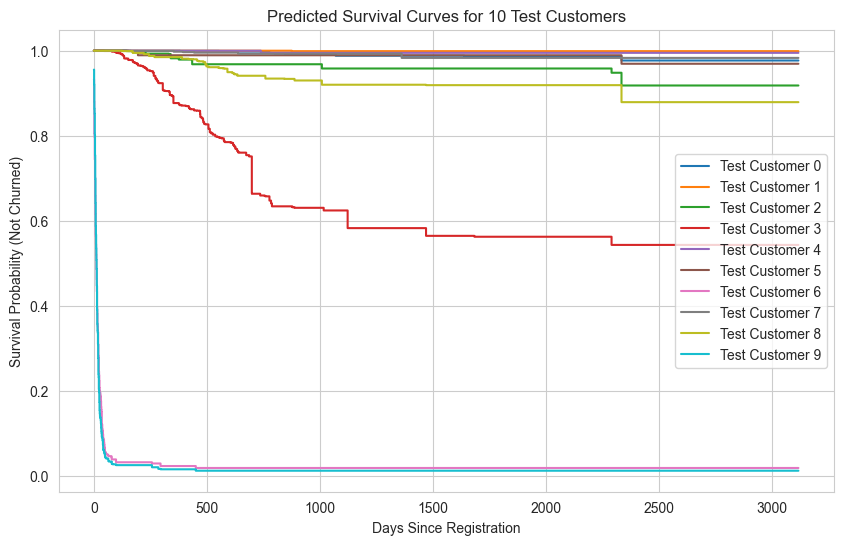

A steep drop means high churn risk. A flat line at the top means low churn risk.


In [19]:
# Predict the full survival functions for the first 10 test customers
surv_funcs = model_pipeline.predict_survival_function(X_test.head(10))

# Plot the curves
plt.figure(figsize=(10, 6))
for i, func in enumerate(surv_funcs):
    plt.step(func.x, func.y, where="post", label=f"Test Customer {i}")

plt.title("Predicted Survival Curves for 10 Test Customers")
plt.xlabel("Days Since Registration")
plt.ylabel("Survival Probability (Not Churned)")
plt.legend()
plt.grid(True)
plt.show()

print("A steep drop means high churn risk. A flat line at the top means low churn risk.")

---

## Actionable Output (30-Day Churn Probability)
This is the main deliverable: a list of customers likely to churn soon. (assume the analysis date is today)
- Filter for all active customers.
- Use the trained model to predict a risk score for them.
- Rank them from highest risk to lowest churn probability.

The Product team can use this list for targeted interventions.

In [20]:
from scipy.interpolate import interp1d

# 1. Get all active customers' features (X) and their current duration (t)
all_features = X.columns
active_customers_X = df_final[df_final['is_churned'] == 0][all_features]
active_customers_info = df_final[df_final['is_churned'] == 0][['customer_id', 'duration_days']].copy()

print(f"Total active customers to score: {len(active_customers_X)}")

# 2. Predict the full survival function for all active customers
print("Predicting survival functions...")
surv_funcs = model_pipeline.predict_survival_function(active_customers_X)

# 3. Define the time points needed for calculation
t_today = active_customers_info['duration_days'].values
t_future = t_today + 30 # 30-day window

# 4. interpolate the probabilities from the survival functions
prob_surv_today_list = []
prob_surv_future_list = []

print("Calculating 30-day probabilities...")
for i, func in enumerate(surv_funcs):
    # Create an interpolator for this customer's survival function
    # 'kind=previous' correctly handles the step-function nature
    interpolator = interp1d(
        func.x, 
        func.y, 
        kind='previous', 
        bounds_error=False, 
        fill_value=(1.0, func.y[-1]) # Fill with 1.0 for t<0 and last prob for t>max
    )
    
    # Get P(T > t_today)
    prob_surv_today_list.append(interpolator(t_today[i]))
    
    # Get P(T > t_future)
    prob_surv_future_list.append(interpolator(t_future[i]))

# 5. Calculate the conditional probability of churn
active_customers_info['prob_surv_today'] = prob_surv_today_list
active_customers_info['prob_surv_future'] = prob_surv_future_list

# P(churn | survived) = 1 - P(surv_future | surv_today)
# P(churn | survived) = 1 - ( P(surv_future) / P(surv_today) )
active_customers_info['prob_churn_30_day'] = 1 - (
    active_customers_info['prob_surv_future'] / active_customers_info['prob_surv_today'].replace(0, 1e-9) # Avoid divide by zero
)

# 6. Sort to find the highest-risk customers
df_risk_list_sorted = active_customers_info.sort_values(by='prob_churn_30_day', ascending=False)

print("\n--- Top 20 Most At-Risk Customers (Next 30 Days) ---")
print(df_risk_list_sorted[['customer_id', 'duration_days', 'prob_churn_30_day']].head(20))

# 7. Highlight all customers with a high risk (e.g., > 50% chance to churn)
print("\n--- All Customers with > 50% Churn Risk ---")
high_risk_customers = df_risk_list_sorted[df_risk_list_sorted['prob_churn_30_day'] > 0.5]
print(high_risk_customers[['customer_id', 'duration_days', 'prob_churn_30_day']])

Total active customers to score: 7646
Predicting survival functions...
Calculating 30-day probabilities...

--- Top 20 Most At-Risk Customers (Next 30 Days) ---
      customer_id  duration_days prob_churn_30_day
7520  CUST_007668             27          0.824293
3099  CUST_003164             15          0.739701
3922  CUST_004009              4          0.738257
844   CUST_000873              3          0.737627
5846  CUST_005958             46          0.731465
83    CUST_000100              8          0.731114
58    CUST_000071              6          0.688717
3222  CUST_003290             16           0.67057
9783  CUST_009972             36          0.651771
9328  CUST_009509             38          0.648989
5964  CUST_006078             31          0.644981
63    CUST_000079              5          0.629451
8747  CUST_008916             35          0.600079
754   CUST_000780             31          0.596024
8986  CUST_009157             20          0.572317
8276  CUST_008440      

---

## Plot 30-Day Churn Forecast

Given this customer is active today (analysis date), what is the probability they will churn by Day 1, Day 5, Day 30, etc.?

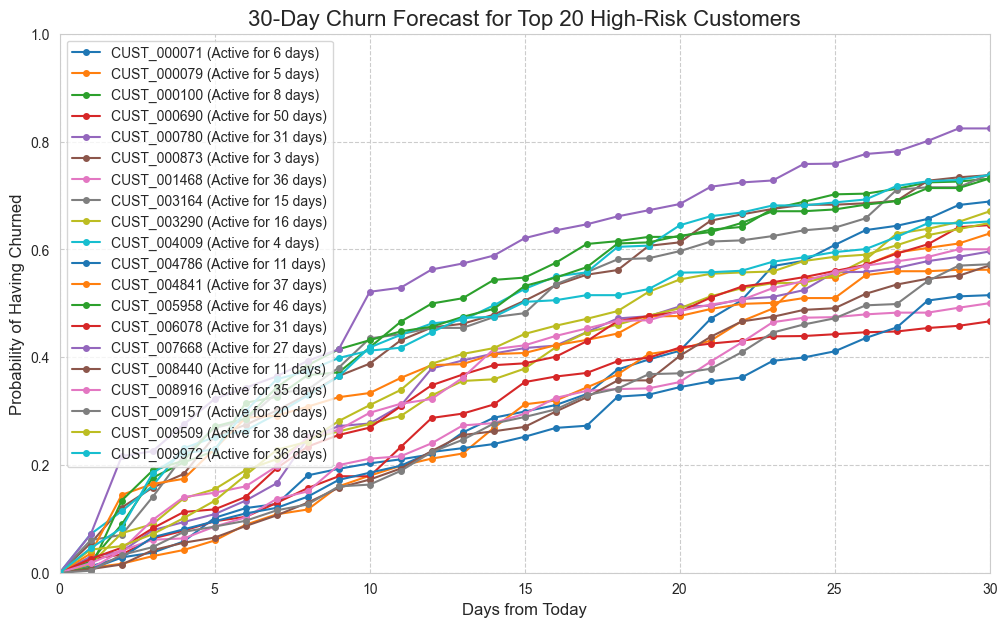

In [21]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# 1. Get the Top 20 most at-risk customers from the previous process
top_20_risk_customers = df_risk_list_sorted.head(20)
top_20_customer_ids = top_20_risk_customers['customer_id']

# 2. Get their feature data (X) and current duration
top_20_X = df_final[df_final['customer_id'].isin(top_20_customer_ids)][all_features]
top_20_info = df_final[df_final['customer_id'].isin(top_20_customer_ids)][['customer_id', 'duration_days']]

# 3. Predict the survival functions for just these 20
surv_funcs_top_20 = model_pipeline.predict_survival_function(top_20_X)

# 4. Create the 30-day forecast plot
plt.figure(figsize=(12, 7))
days_axis = np.arange(0, 31) # 0 to 30 days

for i, func in enumerate(surv_funcs_top_20):
    # Get this customer's info
    customer_id = top_20_info.iloc[i]['customer_id']
    t_today = top_20_info.iloc[i]['duration_days']
    
    # Create the interpolator
    interpolator = interp1d(
        func.x, 
        func.y, 
        kind='previous', 
        bounds_error=False, 
        fill_value=(1.0, func.y[-1])
    )
    
    # Get P(T > t_today)
    prob_surv_today = interpolator(t_today)
    
    # Get probability of surviving for the next 30 days
    t_future = t_today + days_axis
    prob_surv_future = interpolator(t_future)
    
    # Calculate conditional churn probability: 1 - ( S(t+k) / S(t) )
    prob_churn_conditional = 1 - (prob_surv_future / prob_surv_today)
    
    # Plot the forecast
    plt.plot(days_axis, prob_churn_conditional, label=f"{customer_id} (Active for {t_today} days)", marker='o', markersize=4)

# 5. Format the plot
plt.title("30-Day Churn Forecast for Top 20 High-Risk Customers", fontsize=16)
plt.xlabel("Days from Today", fontsize=12)
plt.ylabel("Probability of Having Churned", fontsize=12)
plt.ylim(0, 1.0)
plt.xlim(0, 30)
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

---

## Average 30-Day Churn Forecast by Risk Group

Grouping customers into 30-day risk buckets...
Calculating forecasts for each risk group...


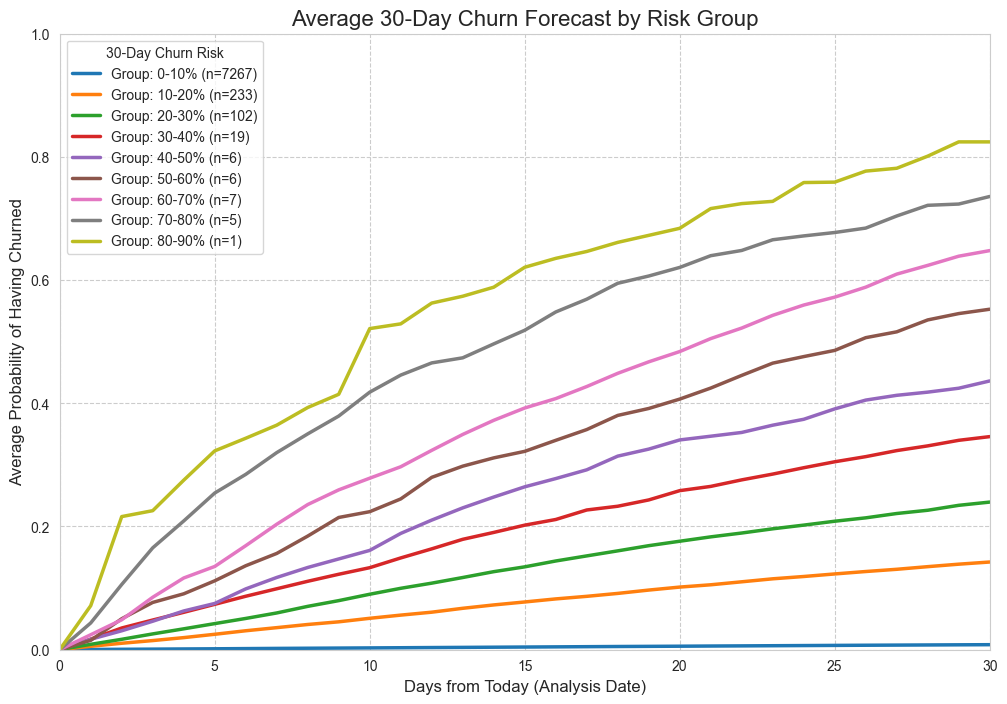

In [22]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

print("Grouping customers into 30-day risk buckets...")

# 1. Define the risk bins and labels
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# 2. Add 'risk_group' to sorted list
# use df_risk_list_sorted which has all active customers and their 30-day risk
df_risk_list_sorted['risk_group'] = pd.cut(
    df_risk_list_sorted['prob_churn_30_day'], 
    bins=bins, 
    labels=labels, 
    right=False
)

# 3. need the survival functions (surv_funcs)
#    and the active customers' info (active_customers_info)
forecasts_by_group = {label: [] for label in labels}
days_axis = np.arange(0, 31) # 0 to 30 days

print("Calculating forecasts for each risk group...")
# 4. Loop through each customer's survival function
for i, func in enumerate(surv_funcs):
    # Get this customer's info
    customer_id = active_customers_info.iloc[i]['customer_id']
    t_today = active_customers_info.iloc[i]['duration_days']
    
    # Find which risk group this customer belongs to
    try:
        risk_group = df_risk_list_sorted.loc[customer_id, 'risk_group']
    except KeyError:
        # Handle cases if customer_id is not in index (if index wasn't set)
        risk_group_series = df_risk_list_sorted[df_risk_list_sorted['customer_id'] == customer_id]['risk_group']
        if not risk_group_series.empty:
            risk_group = risk_group_series.iloc[0]
        else:
            continue # Skip if not found
            
    if pd.isna(risk_group):
        continue

    # Create the interpolator
    interpolator = interp1d(
        func.x, func.y, kind='previous', 
        bounds_error=False, fill_value=(1.0, func.y[-1])
    )
    
    # Get probabilities
    prob_surv_today = interpolator(t_today)
    prob_surv_future = interpolator(t_today + days_axis)
    
    # Calculate conditional churn forecast
    prob_churn_conditional = 1 - (prob_surv_future / (prob_surv_today + 1e-9))
    
    # Add this customer's 30-day forecast to their group
    forecasts_by_group[risk_group].append(prob_churn_conditional)


# 5. Plot the average forecast for each group
plt.figure(figsize=(12, 8))

for risk_group, forecasts in forecasts_by_group.items():
    if not forecasts: # Skip empty groups
        continue
        
    # Calculate the average forecast for the group
    avg_forecast = np.mean(forecasts, axis=0)
    
    # Plot the line
    plt.plot(days_axis, avg_forecast, label=f'Group: {risk_group} (n={len(forecasts)})', linewidth=2.5)

# 6. Format the plot
plt.title("Average 30-Day Churn Forecast by Risk Group", fontsize=16)
plt.xlabel("Days from Today (Analysis Date)", fontsize=12)
plt.ylabel("Average Probability of Having Churned", fontsize=12)
plt.ylim(0, 1.0)
plt.xlim(0, 30)
plt.legend(title="30-Day Churn Risk")
plt.grid(True, linestyle='--')
plt.show()

---

## Feature Importance (Top Churn Drivers)
This tells  why people are churning and can derive the "Top 5 actionable recommendations" based on the features importance.

Calculating feature importances using permutation...

--- Top 15 Most Important Features (from Permutation) ---
                        feature  importance_mean  importance_std
12             avg_logins_count         0.135415        0.002933
2              account_age_days         0.019212        0.000512
6      total_transactions_count         0.003819        0.001062
10             unique_merchants         0.003310        0.000771
11            unique_categories         0.002115        0.000591
8                  total_amount         0.001457        0.000514
9                    avg_amount         0.001058        0.000190
3                          tier         0.000879        0.000179
15         avg_session_duration         0.000604        0.000160
1                         state         0.000148        0.000073
13            total_crash_count         0.000048        0.000043
16   push_notifications_enabled         0.000044        0.000029
21    avg_resolution_time_hours         0.0

C:\Users\User\AppData\Local\Temp\ipykernel_30968\3137562791.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


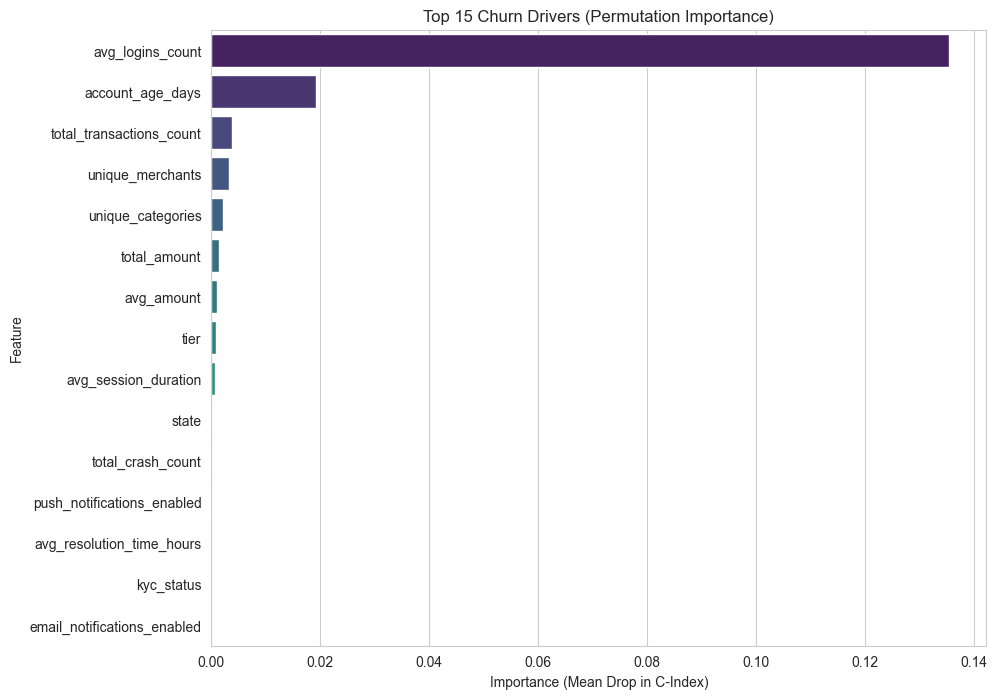

In [23]:
from sklearn.inspection import permutation_importance

print("Calculating feature importances using permutation...")

# 1. run permutation_importance on the test set for an unbiased view.
# It will use the pipeline's default score, which for RSF is the C-Index.
# n_repeats=5 gives a stable average.
result = permutation_importance(
    model_pipeline, 
    X_test, 
    y_test, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=-1
)

# 2. Create a DataFrame of feature importances
# The importances are matched to the original columns in X
df_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("\n--- Top 15 Most Important Features (from Permutation) ---")
print(df_importance.head(15))

# 4. Plot the importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance_mean',
    y='feature',
    data=df_importance.head(15),
    palette='viridis'
)
plt.title("Top 15 Churn Drivers (Permutation Importance)")
plt.xlabel("Importance (Mean Drop in C-Index)")
plt.ylabel("Feature")
plt.show()

---

## 🎯 Top 5 Actionable Recommendations

Our model's high C-Index of **0.976** indicates it is extremely effective. The feature importance plot (Cell 17) tells a clear story: the primary drivers of churn are **`avg_logins_count`**, **`account_age_days`**, and **`total_transactions_count`**.

This analysis reveals that our biggest challenge is **"infant churn"**—a failure to successfully activate new users. The model is exceptionally good at identifying new customers (low `account_age_days`) who do not engage with the app (`avg_logins_count` and `total_transactions_count` are low) and are therefore almost certain to churn.

Based on these data-driven insights, here are our top 5 recommendations:

1.  **Launch a "First 7-Day" Onboarding Campaign:**
    * **Insight:** `avg_logins_count` is the #1 churn driver. The first week is critical.
    * **Recommendation:** We should implement an automated email and push notification series for new signups. The campaign's goal must be to guide the user to log in and complete **one key action** (like making their first payment) to establish an initial habit.

2.  **Incentivize the First Transaction:**
    * **Insight:** `total_transactions_count` is a top-3 driver. Users who never transact are a major flight risk.
    * **Recommendation:** We should offer a small, immediate reward for a user's *first* successful transaction (e.g., "RM1 cashback on your first bill payment"). This will help get users over the initial hurdle.

3.  **Create a "New User At-Risk" Dashboard:**
    * **Insight:** The model is excellent at identifying at-risk new users.
    * **Recommendation:** We can use the 30-day churn probability forecast (from Cell 18) to create a daily dashboard of all users with `account_age_days` < 30 who have a >50% churn probability. This becomes a high-priority list for the Growth Team to re-engage immediately.

4.  **Introduce Tier-Based Onboarding:**
    * **Insight:** The `tier` feature was also predictive. A one-size-fits-all onboarding may not be optimal.
    * **Recommendation:** We should A/B test the onboarding flow. 'Premium' users might be more motivated by feature-based education, while 'Basic' users might respond better to the cashback incentive (Recommendation #2).

5.  **Promote "Sticky" Features Post-Activation:**
    * **Insight:** Minor features like `avg_session_duration` show that users who spend *more time* in the app are "stickier."
    * **Recommendation:** Once a user completes their first transaction, we should guide them to a feature that encourages repeated use, such as setting up a "Scheduled Payment" or using a financial overview tool.

---

## ⚙️ Deployment Considerations

To make this model actionable, we should productionalize it using a robust MLOps pipeline.

* **1. Experiment Tracking (MLflow):**
    Our notebook serves as the experiment. We will use **MLflow** to track our model's parameters (like `n_estimators`) and metrics (C-Index). The final trained `model_pipeline` (preprocessor + model) will be logged to the **MLflow Model Registry**, creating a versioned "golden copy" for deployment.

* **2. CI/CD (GitLab CI/CD):**
    We will refactor the notebook's code into Python scripts (`feature_engineering.py`, `train.py`) and store them in a **GitLab repository**. A `.gitlab-ci.yml` file will create a CI/CD pipeline that automatically runs unit tests on our code. When we merge to the `main` branch, it will trigger the `train.py` script to train and save the latest model to the MLflow Registry.

* **3. Orchestration (Airflow):**
    We will use **Airflow** to schedule and run the prediction job (e.g., weekly). We can create a DAG (Directed Acyclic Graph) with the following tasks:
    1.  **`T1_get_active_customers`**: Queries the production database for all users with `is_churned = 0`.
    2.  **`T2_generate_features`**: Runs our `feature_engineering.py` script to build the point-in-time feature table for these users.
    3.  **`T3_load_model`**: Fetches the "Production" version of our model from the MLflow Model Registry.
    4.  **`T4_predict`**: Calculates the 30-day churn probability for every active customer (as in Cell 18).
    5.  **`T5_save_predictions`**: Writes these `customer_id`s and probabilities to a production table (`churn_forecasts`) for the Marketing and Product teams to use.

* **4. Monitoring (Airflow + Great Expectations):**
    We will use Airflow alerts to notify us via Slack or email if any task fails. We can also add a **Great Expectations** task after T1 to validate the source data quality *before* running predictions, ensuring our model is not scoring on bad data.

---